In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/New_best_model/'

In [ ]:
def create_dataset(serie, time_steps=1):
    Xs, ys = [], []
    for i in range(len(serie) - time_steps):
        Xs.append(serie.iloc[i:(i + time_steps)].values)
        ys.append(serie.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


# Import Models, Data and Predict

## Load

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

grid_load_model = load_model(model_path + 'best_model_RNN_LOAD.h5', custom_objects={
    'mse': MeanSquaredError(),
    'mae': MeanAbsoluteError()
})


grid_load_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,771 (65.52 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/Data/'

load_df = pd.read_excel(dir_path + 'Total_Load.xlsx')

start_date = pd.to_datetime('2022-06-07 00:00')

# Transform our Time to date_time
load_df['Time'] = start_date + pd.to_timedelta(load_df['Time'], unit='s')

In [ ]:
load_df.tail()

,Time,Load
5248,2023-01-11 16:00:00,13.943496
5249,2023-01-11 17:00:00,16.146784
5250,2023-01-11 18:00:00,15.115618
5251,2023-01-11 19:00:00,14.998644
5252,2023-01-11 20:00:00,14.558884


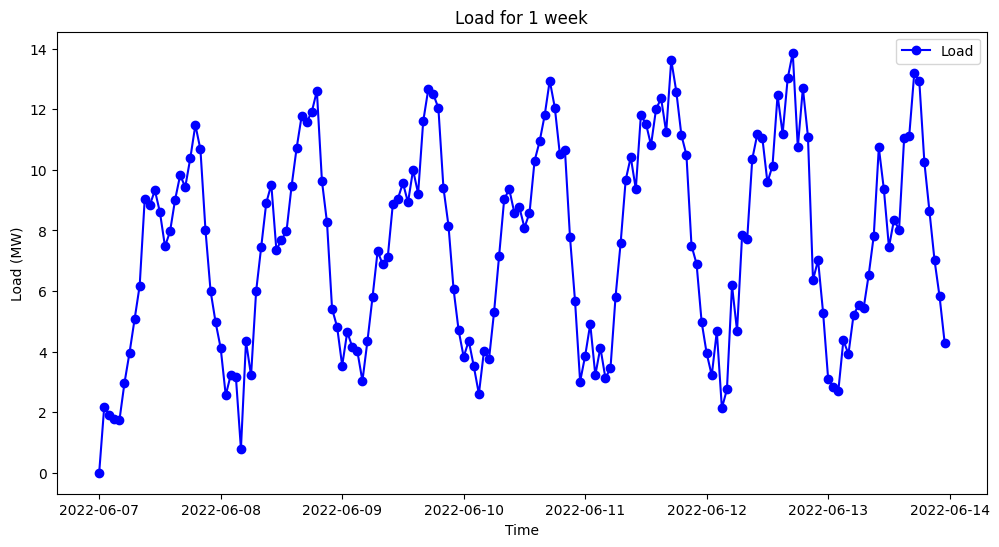

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(load_df['Time'][:168],load_df['Load'][:168], label='Load', color='blue', marker='o', linestyle='-')
plt.title("Load for 1 week")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()

In [ ]:
time_steps = 15
X_load, y_load = create_dataset(load_df['Load'], time_steps)

scaler_load = MinMaxScaler()
X_load = scaler_load.fit_transform(X_load.reshape(-1, 1)).reshape((X_load.shape[0], time_steps, 1))

y_load = scaler_load.fit_transform(y_load.reshape(-1, 1))


# Split into training and testing sets like already did in training
X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(X_load, y_load,train_size=4800, random_state=42, shuffle=False)
print('Train shape:', X_train_load.shape)
print('Test shape:', X_test_load.shape)

Train shape: (4800, 15, 1)
Test shape: (438, 15, 1)


In [ ]:
load_pred = grid_load_model.predict(X_test_load)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Text(0.5, 1.0, 'Load Predictions using best model (RNN) ')

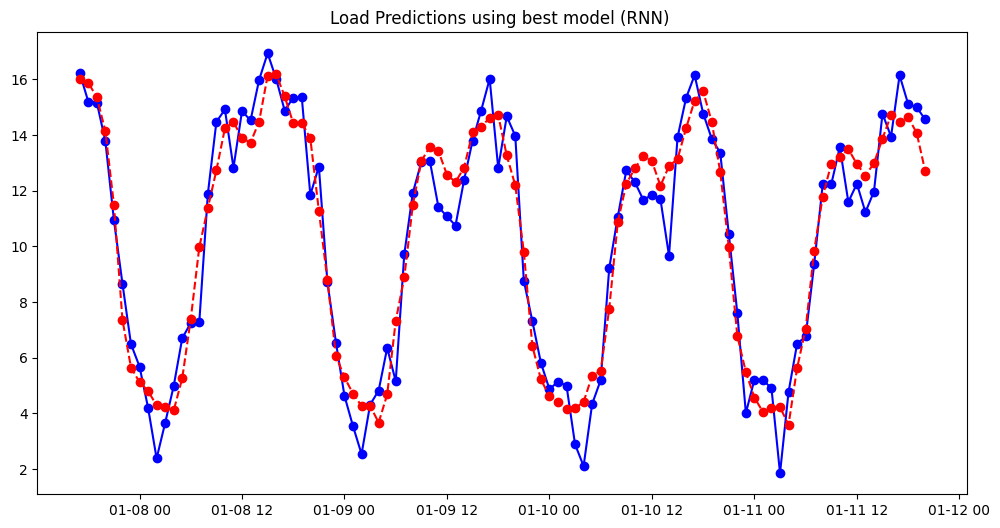

In [ ]:

y_test_load_inv = scaler_load.inverse_transform(y_test_load)
load_pred_inv = scaler_load.inverse_transform(load_pred)


plt.figure(figsize=(12, 6))
plt.plot(load_df['Time'].values[-100:],y_test_load_inv[-100:], label='True Values', color='blue', marker='o', linestyle='-')
plt.plot(load_df['Time'].values[-100:],load_pred_inv[-100:], label='Predictions', color='red', marker='o', linestyle='--')
plt.title("Load Predictions using best model (RNN) ")

## Solar Energy

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/Data/'

solar_energy_df = pd.read_excel(dir_path + 'cleaned_solar_energy.xlsx')

start_date = pd.to_datetime('2022-06-07 00:00')

# Transform our Time to date_time
solar_energy_df['Time'] = start_date + pd.to_timedelta(solar_energy_df['Time'], unit='s')

In [ ]:
solar_energy_df.tail()

,Time,SolarEnergy
5248,2023-01-11 16:00:00,0.582284
5249,2023-01-11 17:00:00,0.033335
5250,2023-01-11 18:00:00,0.000000
5251,2023-01-11 19:00:00,0.000000
5252,2023-01-11 20:00:00,0.000000


In [ ]:
time_steps = 15
X_solar, y_solar = create_dataset(solar_energy_df['SolarEnergy'], time_steps)

scaler_solar = MinMaxScaler()
X_solar_scaled = scaler_solar.fit_transform(X_solar.reshape(-1, 1)).reshape((X_solar.shape[0], time_steps, 1))

y_solar_scaled = scaler_solar.fit_transform(y_solar.reshape(-1, 1))


X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(X_solar_scaled, y_solar_scaled,train_size=4800, random_state=42, shuffle=False)
print('Train shape:', X_train_solar.shape)
print('Test shape:', X_test_solar.shape)

Train shape: (4800, 15, 1)
Test shape: (438, 15, 1)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

solar_energy_model = load_model(model_path + 'best_model_BILSTM_SolarEnergy.h5', custom_objects={
    'mse': MeanSquaredError(),
    'mae': MeanAbsoluteError()
})


solar_energy_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 576)            │       668,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,739 (2.55 MB)

 Trainable params: 668,737 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
solar_energy_pred = solar_energy_model.predict(X_test_solar)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Text(0.5, 1.0, 'Solar Enegy Predictions with best model(GRU) for 4 days')

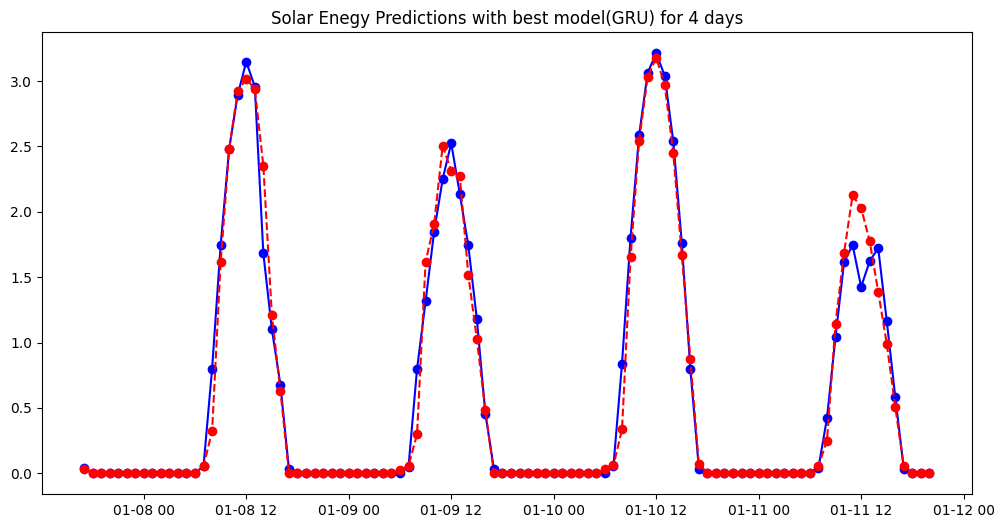

In [ ]:

y_test_solar_inv = scaler_solar.inverse_transform(y_test_solar)
solar_energy_pred_inv = scaler_solar.inverse_transform(solar_energy_pred)




plt.figure(figsize=(12, 6))
plt.plot(load_df['Time'].values[-100:],y_test_solar_inv[-100:], label='True Values', color='blue', marker='o', linestyle='-')
plt.plot(load_df['Time'].values[-100:],solar_energy_pred_inv[-100:], label='Predictions', color='red', marker='o', linestyle='--')
plt.title("Solar Enegy Predictions with best model(GRU) for 4 days")

## Energy disponible to use from EV

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

EV_model = load_model(model_path + 'RNN_CarsEnergy_v2g.h5', custom_objects={
    'mse': MeanSquaredError(),
    'mae': MeanAbsoluteError()
})


EV_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,307 (259.02 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/Data/'

EV_dispo_df = pd.read_excel(dir_path + 'total_power_EV_disponible.xlsx')

EV_dispo_df.tail()

,Time,total_usable_power_MW,total_usable_power_MW_profile_2,total_usable_power_MW_profile_3,total_usable_power_MW_profile_4,total_usable_power_MW_profile_5,total_usable_power_all_profiles_MW
5248,2023-01-11 16:00:00,0.854,0.37,0.056,0.504,0.0,1.784
5249,2023-01-11 17:00:00,0.546,0.00,0.000,0.496,0.0,1.042
5250,2023-01-11 18:00:00,0.728,0.00,0.000,0.560,0.0,1.288
5251,2023-01-11 19:00:00,0.798,0.00,0.136,0.520,0.0,1.454
5252,2023-01-11 20:00:00,0.000,0.00,0.000,0.536,0.0,0.536


In [ ]:
X_ev, y_ev = create_dataset(EV_dispo_df['total_usable_power_all_profiles_MW'], time_steps)

scaler_ev = MinMaxScaler()
X_ev_scaled = scaler_ev.fit_transform(X_ev.reshape(-1, 1)).reshape((X_ev.shape[0], time_steps, 1))

y_ev_scaled = scaler_ev.fit_transform(y_ev.reshape(-1, 1))


X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(X_ev_scaled, y_ev_scaled, train_size=4800, shuffle=False)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


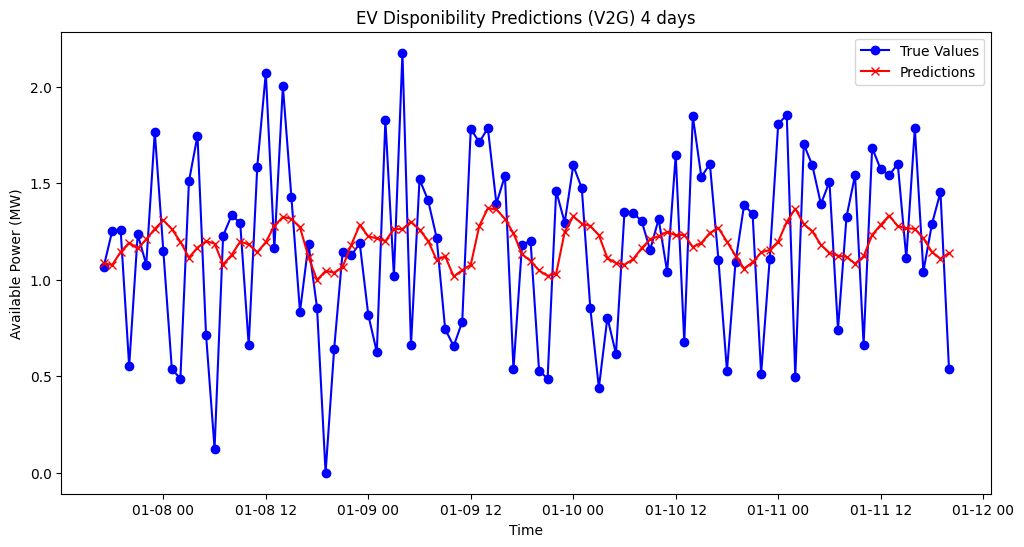

In [ ]:
from sklearn.metrics import r2_score

energy_dispo_pred = EV_model.predict(X_test_ev)

y_test_ev_inv = scaler_ev.inverse_transform(y_test_ev)
energy_dispo_pred_inv = scaler_ev.inverse_transform(energy_dispo_pred)


plt.figure(figsize=(12, 6))
plt.plot(load_df['Time'].values[-100:], y_test_ev_inv[-100:], label='True Values', color='blue', marker='o')
plt.plot(load_df['Time'].values[-100:], energy_dispo_pred_inv[-100:], label='Predictions', color='red', marker='x')
plt.title("EV Disponibility Predictions (V2G) 4 days")
plt.xlabel("Time")
plt.ylabel("Available Power (MW)")
plt.legend()
plt.show()


In [ ]:
# evaluate
mse_ai_ev_dispo = np.mean((energy_dispo_pred_inv - y_test_ev_inv) ** 2)
mae_ai_ev_dispo = np.mean(np.abs(energy_dispo_pred_inv - y_test_ev_inv))
r2_ai_ev_dispo = r2_score(y_test_ev_inv, energy_dispo_pred_inv)

print("MSE:", mse_ai_ev_dispo)
print("MAE:", mae_ai_ev_dispo)
print("R2:", r2_ai_ev_dispo)

MSE: 0.17247854014994282
MAE: 0.3464598746898511
R2: 0.04893524817456074


At first, we thought that the energy availability data was random and couldn’t be predicted. However, after doing a statistical analysis, we found that it actually has patterns that can be predicted (seasonality).

## Diesel Price

In [ ]:
# until now we will suppose that Diesel price is constant and choosen by user
# the model we trained using AI approaches has overfitted due to insufficient data
# even machine learning algorithms did not perform effectively.

# Optimisation Problem

In [ ]:
!pip uninstall ecos -y
!pip install ecos


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
print("Load prediction (inv):", load_pred_inv[:10])
print("Solar prediction (inv):", solar_energy_pred_inv[:10])
print("V2G availability (inv):", energy_dispo_pred_inv[:10])

Load prediction (inv): [[15.471255]
 [15.649788]
 [15.053712]
 [15.050993]
 [14.846792]
 [14.104125]
 [12.199234]
 [ 8.669703]
 [ 5.304786]
 [ 4.724127]]
Solar prediction (inv): [[1.3989748 ]
 [0.66895795]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
V2G availability (inv): [[1.2422454]
 [1.1949958]
 [1.1767709]
 [1.1241027]
 [1.1474675]
 [1.1416068]
 [1.1718749]
 [1.1657573]
 [1.1954173]
 [1.2798381]]


In [ ]:

# V2G price set to 200 MAD/MWh to reflect real-world costs such as:
# Battery degradation from frequent charging/discharging
# Compensation or incentive for EV owners providing grid support
# Energy conversion losses and operational costs
v2g_price = 200     # MAD/MWh

# Diesel price calculation
diesel_price = 2500 # MAD/MWh

In [ ]:
# verify if values are positive
load_pred_opt = load_pred[:168]
solar_pred = solar_energy_pred[:168]
v2g_pred = energy_dispo_pred[:168]

print("Negative values in load_pred_opt:", (load_pred_opt < 0).sum())
print("Negative values in solar_pred:", (solar_pred < 0).sum())
print("Negative values in v2g_pred:", (v2g_pred < 0).sum())

Negative values in load_pred_opt: 0
Negative values in solar_pred: 0
Negative values in v2g_pred: 0


In [ ]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these are your data variables
# If you need to modify how they're loaded, adjust accordingly
date_range = load_df['Time'][4800:4800+168]

# Time horizon: 7 days * 24 hours = 168 hours
T = 168

# Predictions
load_pred_opt = load_pred_inv[:168]         # Load in MW
solar_pred = solar_energy_pred_inv[:168]      # Solar generation in MW
v2g_pred = energy_dispo_pred_inv[:168]         # V2G available in MW

# V2G price set to 200 MAD/MWh
v2g_price = 200     # MAD/MWh

# Diesel price calculation
diesel_price = 2500 # MAD/MWh

# Decision variables
solar_used = cp.Variable(T, nonneg=True)
v2g_used = cp.Variable(T, nonneg=True)
diesel_used = cp.Variable(T, nonneg=True)

# Objective function: Minimize total cost in MAD
total_cost = (cp.sum(diesel_used) * diesel_price +
              cp.sum(cp.multiply(v2g_used, v2g_price)))
objective = cp.Minimize(total_cost)

# Constraints
constraints = []

for t in range(T):
    # Load balance constraint
    constraints.append(solar_used[t] + v2g_used[t] + diesel_used[t] >= load_pred_opt[t])

    # Solar constraint: Use solar, but not more than available
    constraints.append(solar_used[t] <= solar_pred[t])

    # V2G constraint: Use up to available V2G energy
    constraints.append(v2g_used[t] <= v2g_pred[t])

# V2G constraint: use only 3 hours per day max
# Using binary variables for tracking when V2G is used
v2g_binary = cp.Variable((T,), boolean=True)
M = 1000  # big-M value - ensure this is large enough for your data

# Link binary variables to V2G usage
for t in range(T):
    # If V2G is used at all, binary must be 1
    constraints.append(v2g_used[t] <= M * v2g_binary[t])

# Limit V2G usage per day
for d in range(7):
    day_start = d * 24
    day_end = (d + 1) * 24
    constraints.append(cp.sum(v2g_binary[day_start:day_end]) <= 3)  # Up to 3 hours per day

# Solve the problem with more relaxed parameters
problem = cp.Problem(objective, constraints)

# Try multiple solvers
solvers_to_try = [cp.ECOS_BB, cp.CBC, cp.GLPK_MI]
solved = False

for solver in solvers_to_try:
    try:
        print(f"Trying solver: {solver}")
        if solver == cp.ECOS_BB:
            # Add tolerance parameters for ECOS_BB
            result = problem.solve(solver=solver, verbose=True,
                                  abstol=1e-4, reltol=1e-4, feastol=1e-4)
        else:
            result = problem.solve(solver=solver, verbose=True)

        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            solved = True
            print(f"Solved with {solver}")
            break
        else:
            print(f"Failed with {solver}, status: {problem.status}")
    except Exception as e:
        print(f"Error with {solver}: {e}")

# Results and handling solver status
if solved:
    print(f"Optimization status: {problem.status}")
    print(f"Total diesel energy used: {sum(diesel_used.value):.2f} MWh")
    print(f"Total diesel cost: {sum(diesel_used.value) * diesel_price:.2f} MAD")
    print(f"Total V2G energy used: {sum(v2g_used.value):.2f} MWh")

    # Output table
    results = pd.DataFrame({
    "Hour": np.arange(1, T + 1),
    "Load (MW)": load_pred_opt.flatten() if hasattr(load_pred_opt, "shape") else load_pred_opt,
    "Solar Used (MW)": solar_used.value.flatten(),
    "V2G Used (MW)": v2g_used.value.flatten(),
    "Diesel Used (MW)": diesel_used.value.flatten(),
    "Date": date_range.values if hasattr(date_range, 'values') else date_range
})

    # Show peak hours when V2G is used
    peak_v2g = results[results["V2G Used (MW)"] > 1e-4]
    print("\nV2G Used During These Peak Hours (likely high load):")
    if not peak_v2g.empty:
        print(peak_v2g[["Hour", "Date", "Load (MW)", "V2G Used (MW)"]])
    else:
        print("No V2G usage detected")

else:
    print(f"Problem could not be solved with any of the attempted solvers.")
    print(f"Final status: {problem.status}")


Trying solver: ECOS_BB
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 10 08:33:03 PM: Your problem has 672 variables, 679 constraints, and 0 parameters.
(CVXPY) May 10 08:33:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 10 08:33:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 10 08:33:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 10 08:33:03 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 10 08:33:03 PM: Compiling problem 

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
results.head()

,Hour,Load (MW),Solar Used (MW),V2G Used (MW),Diesel Used (MW),Date
0,1,15.471255,1.391846,0.044719,14.042000,2022-12-24 00:00:00
1,2,15.649788,0.662027,0.053035,14.942034,2022-12-24 01:00:00
2,3,15.053712,0.000000,0.055678,15.005344,2022-12-24 02:00:00
3,4,15.050993,0.000000,0.057516,15.000788,2022-12-24 03:00:00
4,5,14.846792,0.000000,0.057969,14.796134,2022-12-24 04:00:00


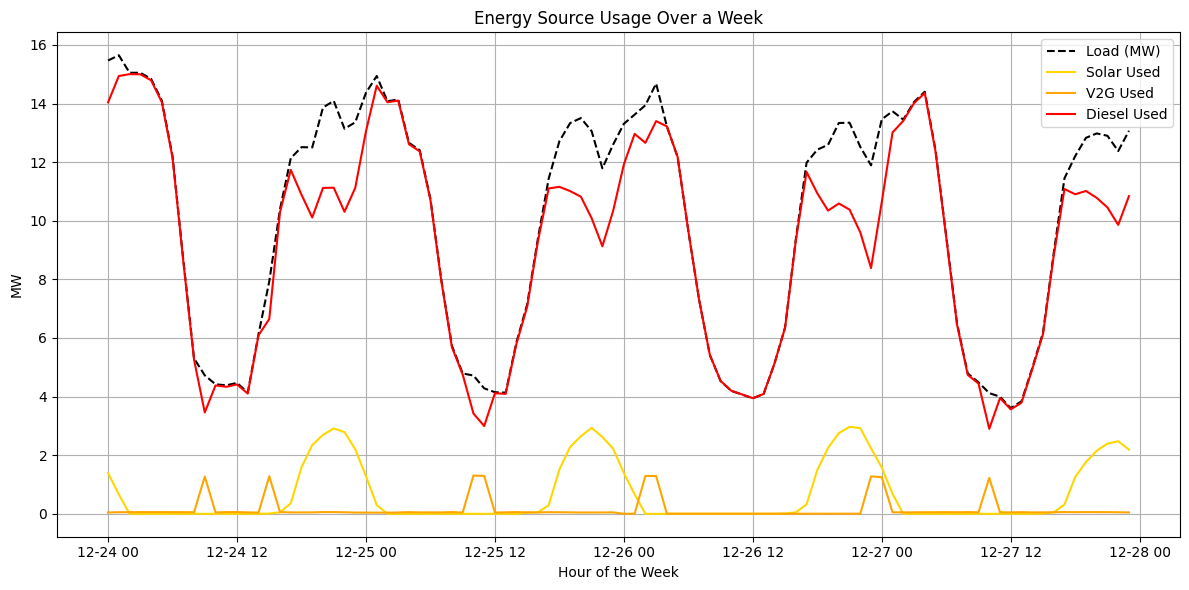

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results['Date'][:96], results['Load (MW)'][:96], label="Load (MW)", color="black", linestyle="--")
plt.plot(results['Date'][:96], results['Solar Used (MW)'][:96], label="Solar Used", color="gold")
plt.plot(results['Date'][:96], results['V2G Used (MW)'][:96], label="V2G Used", color="orange")
plt.plot(results['Date'][:96], results['Diesel Used (MW)'][:96], label="Diesel Used", color="red")
plt.title("Energy Source Usage Over a Week")
plt.xlabel("Hour of the Week")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# if we don't use v2g discharge
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these are your data variables
# If you need to modify how they're loaded, adjust accordingly
date_range = load_df['Time'][4800:4800+168]

# Time horizon: 7 days * 24 hours = 168 hours
T = 168

# Predictions
load_pred_opt = load_pred_inv[:168]         # Load in MW
solar_pred = solar_energy_pred_inv[:168]      # Solar generation in MW

# Diesel price calculation
diesel_price = 2500 # MAD/MWh

# Decision variables
solar_used = cp.Variable(T, nonneg=True)
diesel_used = cp.Variable(T, nonneg=True)

# Objective function: Minimize total cost in MAD (without V2G)
total_cost_no_v2g = cp.sum(diesel_used) * diesel_price
objective_no_v2g = cp.Minimize(total_cost_no_v2g)

# Constraints (same as before, but without V2G)
constraints_no_v2g = []

for t in range(T):
    # Load balance constraint (without V2G)
    constraints_no_v2g.append(solar_used[t] + diesel_used[t] >= load_pred_opt[t])

    # Solar constraint: Use solar, but not more than available
    constraints_no_v2g.append(solar_used[t] <= solar_pred[t])

# Solve the problem without V2G
problem_no_v2g = cp.Problem(objective_no_v2g, constraints_no_v2g)

# Try multiple solvers
solvers_to_try = [cp.ECOS_BB, cp.CBC, cp.GLPK_MI]
solved_no_v2g = False

for solver in solvers_to_try:
    try:
        print(f"Trying solver: {solver}")
        result_no_v2g = problem_no_v2g.solve(solver=solver, verbose=True)

        if problem_no_v2g.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            solved_no_v2g = True
            print(f"Solved with {solver}")
            break
        else:
            print(f"Failed with {solver}, status: {problem_no_v2g.status}")
    except Exception as e:
        print(f"Error with {solver}: {e}")

# Results and handling solver status
if solved_no_v2g:
    print(f"Optimization status without V2G: {problem_no_v2g.status}")
    print(f"Total diesel energy used (without V2G): {sum(diesel_used.value):.2f} MWh")
    print(f"Total diesel cost (without V2G): {sum(diesel_used.value) * diesel_price:.2f} MAD")

    # Output table
    results_no_v2g = pd.DataFrame({
    "Hour": np.arange(1, T + 1),
    "Load (MW)": load_pred_opt.flatten() if hasattr(load_pred_opt, "shape") else load_pred_opt,
    "Solar Used (MW)": solar_used.value.flatten(),
    "Diesel Used (MW)": diesel_used.value.flatten(),
    "Date": date_range.values if hasattr(date_range, 'values') else date_range
})

    # Show the results
    print(results_no_v2g.head())  # Show first few rows of the results

else:
    print(f"Problem could not be solved without V2G using any of the attempted solvers.")


Trying solver: ECOS_BB
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 10 08:43:29 PM: Your problem has 336 variables, 336 constraints, and 0 parameters.
(CVXPY) May 10 08:43:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 10 08:43:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 10 08:43:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 10 08:43:29 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 10 08:43:29 PM: Compiling problem 

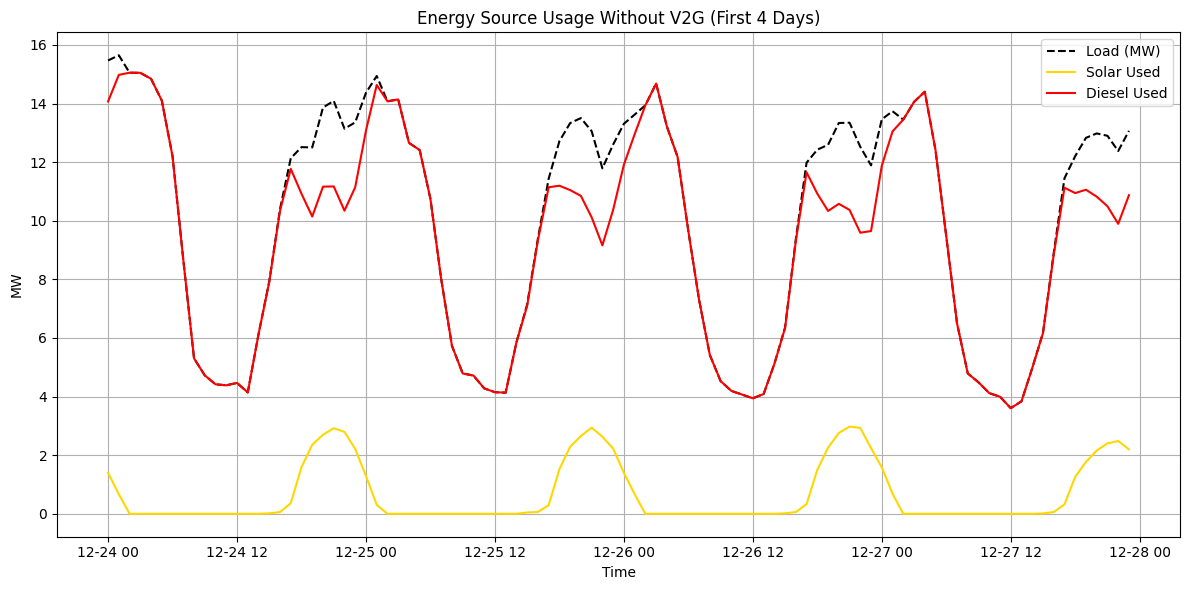

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results_no_v2g['Date'][:96], results_no_v2g['Load (MW)'][:96], label="Load (MW)", color="black", linestyle="--")
plt.plot(results_no_v2g['Date'][:96], results_no_v2g['Solar Used (MW)'][:96], label="Solar Used", color="gold")
plt.plot(results_no_v2g['Date'][:96], results_no_v2g['Diesel Used (MW)'][:96], label="Diesel Used", color="red")
plt.title("Energy Source Usage Without V2G (First 4 Days)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Forecast

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Forecast Load
initial_load = load_df['Load'].values[-15:]
load_scaler = MinMaxScaler()
load_scaler.fit(load_df['Load'].values.reshape(-1, 1))

def forecast_load(model, initial_sequence, n_forecast, scaler, time_steps=15):
    forecast = []
    current_sequence = initial_sequence.copy()
    for _ in range(n_forecast):
        scaled_seq = scaler.transform(current_sequence.reshape(-1, 1)).reshape(1, time_steps, 1)
        next_pred_scaled = model.predict(scaled_seq, verbose=0)[0][0]
        next_pred = scaler.inverse_transform([[next_pred_scaled]])[0][0]
        forecast.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    return np.array(forecast)

load_forecast = forecast_load(grid_load_model, initial_load, 24, load_scaler)

# Forecast Solar
initial_solar = solar_energy_df['SolarEnergy'].values[-15:]
solar_scaler = MinMaxScaler()
solar_scaler.fit(solar_energy_df['SolarEnergy'].values.reshape(-1, 1))

def forecast_solar(model, initial_sequence, n_forecast, scaler, time_steps=15):
    forecast = []
    current_sequence = initial_sequence.copy()
    for _ in range(n_forecast):
        scaled_seq = scaler.transform(current_sequence.reshape(-1, 1)).reshape(1, time_steps, 1)
        next_pred_scaled = model.predict(scaled_seq, verbose=0)[0][0]
        next_pred = scaler.inverse_transform([[next_pred_scaled]])[0][0]
        next_pred = max(next_pred, 0)
        forecast.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    return np.array(forecast)

solar_forecast = forecast_solar(solar_energy_model, initial_solar, 24, solar_scaler)

# Forecast EV
initial_ev = EV_dispo_df['total_usable_power_all_profiles_MW'].values[-15:]
scaler_X_ev = MinMaxScaler()
scaler_y_ev = MinMaxScaler()

# Fit scalers on full series (safe choice)
scaler_X_ev.fit(EV_dispo_df['total_usable_power_all_profiles_MW'].values.reshape(-1, 1))
scaler_y_ev.fit(EV_dispo_df['total_usable_power_all_profiles_MW'].values.reshape(-1, 1))

def forecast_ev(model, initial_sequence, n_forecast, scaler_X, scaler_y, time_steps=15):
    forecast = []
    current_sequence = initial_sequence.copy()
    for _ in range(n_forecast):
        scaled_input = scaler_X.transform(current_sequence.reshape(-1, 1)).reshape(1, time_steps, 1)
        next_pred_scaled = model.predict(scaled_input, verbose=0)[0][0]
        next_pred = scaler_y.inverse_transform([[next_pred_scaled]])[0][0]
        next_pred = max(next_pred, 0)
        forecast.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    return np.array(forecast)

ev_forecast = forecast_ev(EV_model, initial_ev, 24, scaler_X_ev, scaler_y_ev)




<ipython-input-134-9b7d8540c840>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(last_time_load, periods=49, freq='H')[1:]


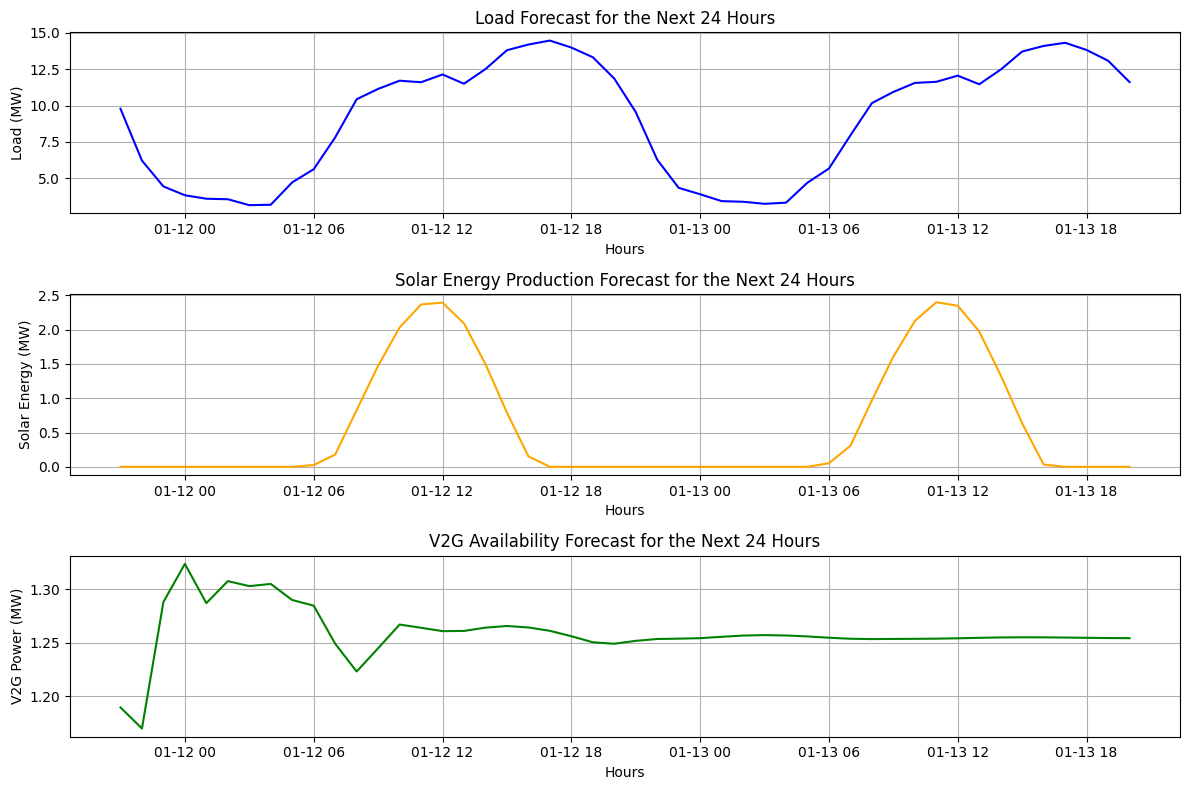

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Last timestamp values
last_time_load = load_df['Time'].values[-1]
last_time_solar = solar_energy_df['Time'].values[-1]
last_time_ev = EV_dispo_df['Time'].values[-1]

# Forecast Load, Solar, EV
load_forecast = forecast_load(grid_load_model, initial_load, 48, load_scaler)
solar_forecast = forecast_solar(solar_energy_model, initial_solar, 48, solar_scaler)
ev_forecast = forecast_ev(EV_model, initial_ev, 48, scaler_X_ev, scaler_y_ev)

# Exclude the starting point to avoid duplication
time_range = pd.date_range(last_time_load, periods=49, freq='H')[1:]


# Plots
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_range, load_forecast, label='Load Forecast', color='b')
plt.title("Load Forecast for the Next 24 Hours")
plt.xlabel('Hours')
plt.ylabel('Load (MW)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_range, solar_forecast, label='Solar Forecast', color='orange')
plt.title("Solar Energy Production Forecast for the Next 24 Hours")
plt.xlabel('Hours')
plt.ylabel('Solar Energy (MW)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_range, ev_forecast, label='V2G Availability Forecast', color='g')
plt.title("V2G Availability Forecast for the Next 24 Hours")
plt.xlabel('Hours')
plt.ylabel('V2G Power (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()
